# MLP with the Adam optimizer trained on the Fashion-MNIST dataset using PyTorch

In [1]:
from torch.optim import Adam
from torch.nn import NLLLoss
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from sklearn.metrics import classification_report
import wandb
from pprint import pprint

from torch_utils import split_data, create_model, fit, evaluate
from plot_utils import plot_training, show_confusion_matrix

## Login to Wandb

In [2]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Load best hyperparameters from the Tensorflow run

In [3]:
api = wandb.Api()
sweep = api.sweep("nsiete23/tf_mlp/sweeps/12a25071")

best_config = sweep.best_run().config
pprint(best_config)

wandb.init(config=best_config, project='torch_mlp', name='best-mlp-torch')
config = wandb.config

wandb: Sorting runs by +summary_metrics.val_loss
wandb: Currently logged in as: v-modroczky (nsiete23). Use `wandb login --relogin` to force relogin


{'batch_size': 128,
 'beta_1': 0.986435025614692,
 'beta_2': 0.9904482393527106,
 'dense_1': 485,
 'dense_2': 176,
 'dense_3': 131,
 'dense_4': 122,
 'epochs': 19,
 'learning_rate': 0.00012885226472854095}


## Load dataset

In [4]:
data = FashionMNIST(root='../data', download=True, transform=ToTensor())
test = FashionMNIST(root='../data', download=True, train=False, transform=ToTensor())

train_loader, val_loader, test_loader = split_data(data, test, batch_size=config.batch_size)

print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw

48000
12000
10000


## Create model

In [5]:
mlp = create_model(config)

loss = NLLLoss()
optimizer = Adam(mlp.parameters(), lr=config.learning_rate, betas=(config.beta_1, config.beta_2))

## Train model and finish Wandb run

In [6]:
history = fit(mlp, train_loader, val_loader, optimizer, loss, config.epochs, config.batch_size)
wandb.finish()

Epoch 1/19: loss 1.1536671412785848, val_loss 0.6919355344772339, accuracy 0.5993333333333334, val_accuracy 0.7325833333333334
Epoch 2/19: loss 0.634277834335963, val_loss 0.5656527795791626, accuracy 0.766, val_accuracy 0.7965
Epoch 3/19: loss 0.543801552216212, val_loss 0.5013695669174194, accuracy 0.8078541666666667, val_accuracy 0.8279166666666666
Epoch 4/19: loss 0.4859077597459157, val_loss 0.4500073585510254, accuracy 0.8293541666666666, val_accuracy 0.84525
Epoch 5/19: loss 0.45278780682881675, val_loss 0.43975549379984535, accuracy 0.8411458333333334, val_accuracy 0.8484166666666667
Epoch 6/19: loss 0.4281736028989156, val_loss 0.4188218866984049, accuracy 0.84925, val_accuracy 0.8546666666666667
Epoch 7/19: loss 0.4104100909233093, val_loss 0.40643049160639444, accuracy 0.8542291666666667, val_accuracy 0.8589166666666667
Epoch 8/19: loss 0.39190225104490917, val_loss 0.39198314905166626, accuracy 0.860625, val_accuracy 0.8603333333333333
Epoch 9/19: loss 0.3797987955411275, v

accuracy,▁▅▆▇▇▇▇▇▇▇▇████████
loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇███████
val_loss,█▆▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
accuracy,0.89129
loss,0.2997
val_accuracy,0.88583
val_loss,0.31973


## Plot training and validation accuracy and loss

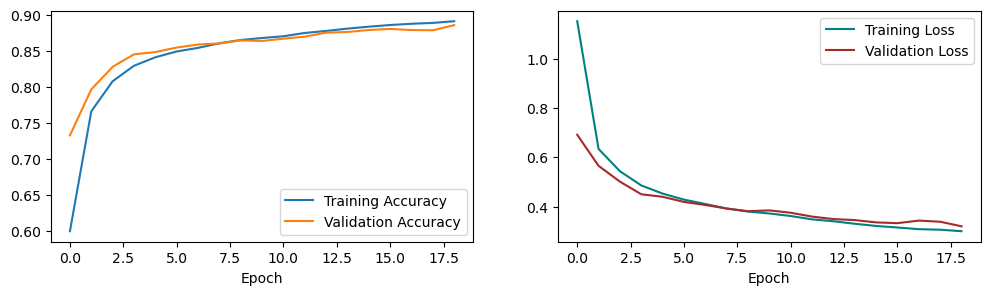

In [7]:
plot_training(
    history['accuracy'],
    history['val_accuracy'],
    history['loss'],
    history['val_loss']
)

## Define class names

In [8]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

## Run classification evaluation

In [9]:
y_test_all, y_pred_all = evaluate(mlp, test_loader)

report = classification_report(y_test_all, y_pred_all, target_names=class_names, digits=4)
print(report)

              precision    recall  f1-score   support

 T-shirt/top     0.8365    0.8340    0.8353      1000
     Trouser     0.9817    0.9630    0.9722      1000
    Pullover     0.8281    0.7420    0.7827      1000
       Dress     0.8961    0.8540    0.8746      1000
        Coat     0.7712    0.8190    0.7944      1000
      Sandal     0.9561    0.9590    0.9576      1000
       Shirt     0.6483    0.7170    0.6809      1000
     Sneaker     0.9302    0.9590    0.9444      1000
         Bag     0.9708    0.9640    0.9674      1000
  Ankle boot     0.9693    0.9480    0.9585      1000

    accuracy                         0.8759     10000
   macro avg     0.8788    0.8759    0.8768     10000
weighted avg     0.8788    0.8759    0.8768     10000



## Visualize confusion matrix

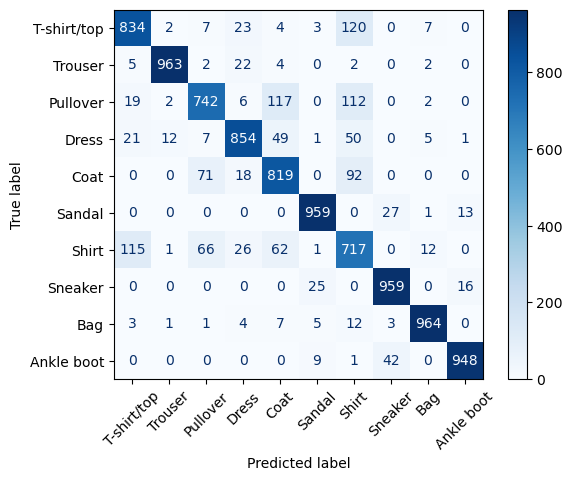

In [10]:
show_confusion_matrix(y_test_all, y_pred_all, class_names)